# Resultados Parciais PIBIC 2021-2022

## Finding and Measuring Lungs in CT Data

[Desafio Kaggle](https://www.kaggle.com/datasets/kmader/finding-lungs-in-ct-data/code)


[Código utilizado como base para a U-net com a biblioteca Keras](https://www.kaggle.com/code/poonsfc5/keras-unet) 

In [1]:
import os
for dirname, _, filenames in os.walk('/content/drive/MyDrive/PIBIC-2022/kaggle/2d_images'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/content/drive/MyDrive/PIBIC-2022/kaggle/2d_images/ID_0000_Z_0142.tif
/content/drive/MyDrive/PIBIC-2022/kaggle/2d_images/ID_0001_Z_0146.tif
/content/drive/MyDrive/PIBIC-2022/kaggle/2d_images/ID_0002_Z_0162.tif
/content/drive/MyDrive/PIBIC-2022/kaggle/2d_images/ID_0003_Z_0132.tif
/content/drive/MyDrive/PIBIC-2022/kaggle/2d_images/ID_0004_Z_0066.tif
/content/drive/MyDrive/PIBIC-2022/kaggle/2d_images/ID_0005_Z_0066.tif
/content/drive/MyDrive/PIBIC-2022/kaggle/2d_images/ID_0006_Z_0206.tif
/content/drive/MyDrive/PIBIC-2022/kaggle/2d_images/ID_0007_Z_0211.tif
/content/drive/MyDrive/PIBIC-2022/kaggle/2d_images/ID_0008_Z_0065.tif
/content/drive/MyDrive/PIBIC-2022/kaggle/2d_images/ID_0009_Z_0114.tif
/content/drive/MyDrive/PIBIC-2022/kaggle/2d_images/ID_0010_Z_0259.tif
/content/drive/MyDrive/PIBIC-2022/kaggle/2d_images/ID_0011_Z_0156.tif
/content/drive/MyDrive/PIBIC-2022/kaggle/2d_images/ID_0012_Z_0167.tif
/content/drive/MyDrive/PIBIC-2022/kaggle/2d_images/ID_0013_Z_0047.tif
/content/drive/MyDri

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline

np.random.seed(2)

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools

In [3]:
!pip install tensorflow==2.4.1 
!pip install keras==2.4.3

     |████████████████████████████████| 394.3 MB 12 kB/s 
     |████████████████████████████████| 132 kB 58.8 MB/s 
     |████████████████████████████████| 3.8 MB 37.8 MB/s 
     |████████████████████████████████| 5.8 MB 28.8 MB/s 
     |████████████████████████████████| 2.9 MB 19.6 MB/s 
     |████████████████████████████████| 14.8 MB 35.8 MB/s 
     |████████████████████████████████| 462 kB 54.7 MB/s 
  Created wheel for wrapt: filename=wrapt-1.12.1-cp37-cp37m-linux_x86_64.whl size=68719 sha256=6db3a3deb0b031fa2ff6a398b7e94364dd6c38d0b856c2c9368e897f4c37852b
  Stored in directory: /root/.cache/pip/wheels/62/76/4c/aa25851149f3f6d9785f6c869387ad82b3fd37582fa8147ac6
Successfully built wrapt
  Attempting uninstall: typing-extensions
    Found existing installation: typing-extensions 3.10.0.2
    Uninstalling typing-extensions-3.10.0.2:
      Successfully uninstalled typing-extensions-3.10.0.2
  Attempting uninstall: numpy
    Found existing installation: numpy 1.21.5
    Uninstalling num

  Attempting uninstall: keras
    Found existing installation: Keras 2.3.1
    Uninstalling Keras-2.3.1:
      Successfully uninstalled Keras-2.3.1


In [4]:
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.models import Model, load_model, save_model, Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, Conv2DTranspose
from tensorflow.keras.layers import Dense, Activation, Dropout, Input, Masking, TimeDistributed, LSTM, Conv1D
from tensorflow.keras.layers import GRU, Bidirectional, BatchNormalization, Reshape
from tensorflow.keras.optimizers import Adam, RMSprop

sns.set(style='white', context='notebook', palette='deep')

In [5]:
from glob import glob    
from skimage.util import montage 
from skimage.io   import imread
%matplotlib inline

In [6]:
BASE_IMG_PATH = '/content/drive/MyDrive/PIBIC-2022/kaggle'
DS_FACT = 2
SEED=42

all_image_files = glob(os.path.join(BASE_IMG_PATH,'2d_images','*.tif'))
all_mask_files  = glob(os.path.join(BASE_IMG_PATH,'2d_masks','*.tif'))

print('No. of images:', len(all_image_files))
print(all_image_files[0])
print(all_mask_files[0])

No. of images: 267
/content/drive/MyDrive/PIBIC-2022/kaggle/2d_images/ID_0000_Z_0142.tif
/content/drive/MyDrive/PIBIC-2022/kaggle/2d_masks/ID_0000_Z_0142.tif


(1, 256, 256)


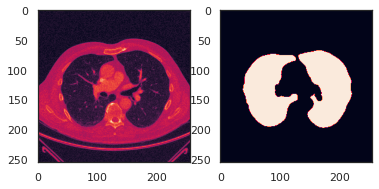

In [7]:
test_image = np.expand_dims(imread(all_image_files[0])[::2, ::2],0)
test_mask  = np.expand_dims(imread(all_mask_files[0])[::2, ::2],0)/255.0
fig, (ax1 ,ax2) = plt.subplots(1, 2)
ax1.imshow(test_image[0])
ax2.imshow(test_mask[0])
print(test_image.shape)

In [8]:
images  = np.stack((np.expand_dims(imread(i)[::DS_FACT, ::DS_FACT], -1) for i in all_image_files),0)
masks   = np.stack((np.expand_dims(imread(i)[::DS_FACT, ::DS_FACT]/255., -1) for i in all_mask_files),0)
                  
X_train, X_test, y_train,  y_test = train_test_split(images, masks, test_size=0.1)

print('X_train - len/shape:', len(X_train), X_train.shape)
print('Y_train is {}, min is {}, max is {}, mean is {}'.format(y_train.shape, y_train.min(), y_train.max(), y_train.mean()))
print('X_test  - len/shape:', len(X_test), y_test.shape)
print(images.shape[:])

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2822: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if self.run_code(code, result):


X_train - len/shape: 240 (240, 256, 256, 1)
Y_train is (240, 256, 256, 1), min is 0.0, max is 1.0, mean is 0.23402748107910157
X_test  - len/shape: 27 (27, 256, 256, 1)
(267, 256, 256, 1)


# U-net model

In [9]:
def unet(inputs, n=32):
    bn    = BatchNormalization()(inputs)  
    conv1 = Conv2D(n, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(bn)
    conv1 = Conv2D(n, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    pool1 = Dropout(0.1)(pool1)

    conv2 = Conv2D(n*2, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(pool1)
    conv2 = Conv2D(n*2, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    pool2 = Dropout(0.1)(pool2)

    conv3 = Conv2D(n*4, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(pool2)
    conv3 = Conv2D(n*4, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    pool3 = Dropout(0.1)(pool3)

    conv4 = Conv2D(n*8, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(pool3)
    conv4 = Conv2D(n*8, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)    
    pool4 = Dropout(0.1)(pool4)

    convm = Conv2D(n*16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(pool4)
    convm = Conv2D(n*16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(convm)

    up6   = Conv2DTranspose(n*8, (2, 2), strides=(2, 2), padding='same')(convm)
    conv6 = concatenate([up6, conv4])
    conv6 = Dropout(0.1)(conv6)                   
    conv6 = Conv2D(n*8, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv6)
    conv6 = Conv2D(n*8, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv6)

    up7   = Conv2DTranspose(n*4, (2, 2), strides=(2, 2), padding='same')(conv6)
    conv7 = concatenate([up7, conv3])
    conv7 = Dropout(0.1)(conv7)
    conv7 = Conv2D(n*4, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv7)
    conv7 = Conv2D(n*4, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv7)

    up8   = Conv2DTranspose(n*2, (2, 2), strides=(2, 2), padding='same')(conv7)
    conv8 = concatenate([up8, conv2])
    conv8 = Dropout(0.1)(conv8)  
    conv8 = Conv2D(n*2, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv8)
    conv8 = Conv2D(n*2, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv8)

    up9   = Conv2DTranspose(n, (2, 2), strides=(2, 2), padding='same')(conv8)
    conv9 = concatenate([up9, conv1])
    conv9 = Dropout(0.1)(conv9) 
    conv9 = Conv2D(n, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv9)
    conv9 = Conv2D(n, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv9)

    output = Conv2D(1, (1, 1), activation='sigmoid')(conv9)

    return Model(inputs=[inputs], outputs=[output])

In [10]:
input_img = Input(X_train.shape[1:], name='img')
n_filters   = 32

model = unet(input_img, n_filters)

model.compile(optimizer=Adam(), loss="binary_crossentropy", metrics=["accuracy"])
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 256, 256, 1)  4           img[0][0]                        
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 32) 320         batch_normalization[0][0]        
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 32) 9248        conv2d[0][0]                     
______________________________________________________________________________________________

In [11]:
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

callbacks = [
    EarlyStopping(patience=10, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=3, min_lr=0.00001, verbose=1),
    ModelCheckpoint('model-lung.h5', verbose=1, save_best_only=True, save_weights_only=True)
]

In [13]:
history = model.fit(X_train, y_train, batch_size=10, epochs=12, callbacks=callbacks, \
                    validation_data=(X_test, y_test))

Epoch 1/12
24/24 [==============================] - 506s 21s/step - loss: 0.3212 - accuracy: 0.8503 - val_loss: 1.0370 - val_accuracy: 0.7527

Epoch 00001: val_loss improved from 1.87091 to 1.03702, saving model to model-lung.h5
Epoch 2/12
24/24 [==============================] - 494s 21s/step - loss: 0.4001 - accuracy: 0.8218 - val_loss: 0.4976 - val_accuracy: 0.7510

Epoch 00002: val_loss improved from 1.03702 to 0.49758, saving model to model-lung.h5
Epoch 3/12
24/24 [==============================] - 496s 21s/step - loss: 0.3312 - accuracy: 0.8110 - val_loss: 0.5120 - val_accuracy: 0.7571

Epoch 00003: val_loss did not improve from 0.49758
Epoch 4/12
24/24 [==============================] - 493s 21s/step - loss: 0.3091 - accuracy: 0.8441 - val_loss: 0.4496 - val_accuracy: 0.7705

Epoch 00004: val_loss improved from 0.49758 to 0.44958, saving model to model-lung.h5
Epoch 5/12
24/24 [==============================] - 497s 21s/step - loss: 0.2768 - accuracy: 0.8796 - val_loss: 0.4371 

In [14]:
def plot_history(history, title):
    plt.figure(figsize=(10,3))
    # Plot training & validation accuracy values
    plt.subplot(121)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')

    # Plot training & validation loss values
    plt.subplot(122)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

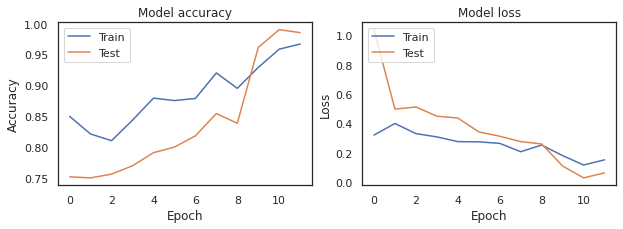

In [15]:
plot_history(history, 'UNet Loss/Accuracy')

In [16]:
model.load_weights('model-lung.h5')

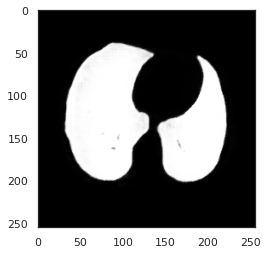

In [17]:
plt.imshow(
    model.predict(X_train[0].reshape(1,256, 256, 1))[0,:,:,0], 
    cmap='gray')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  after removing the cwd from sys.path.


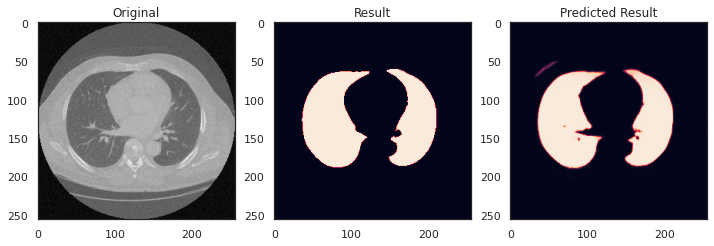

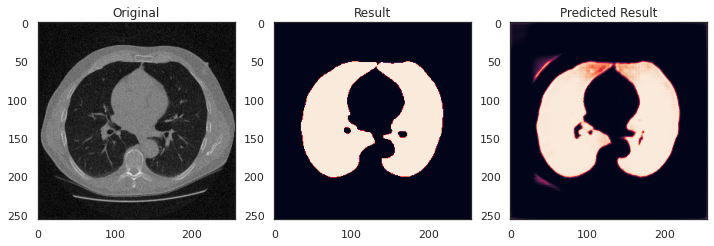

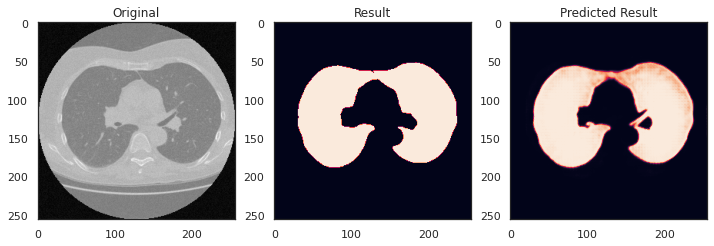

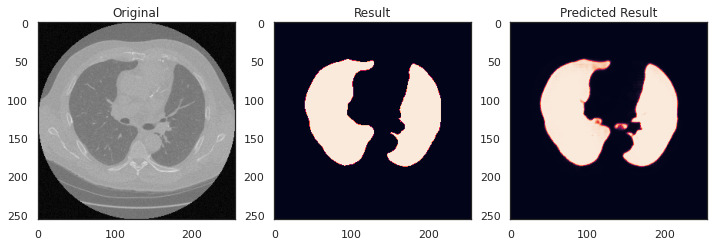

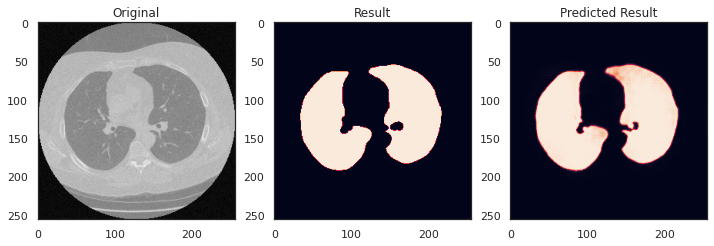

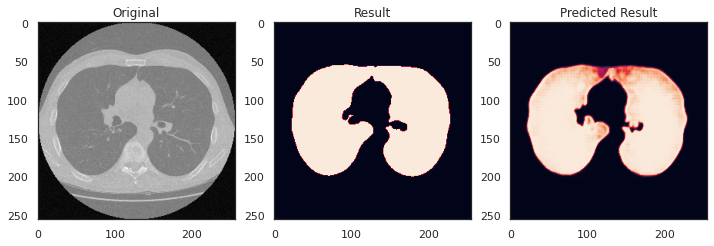

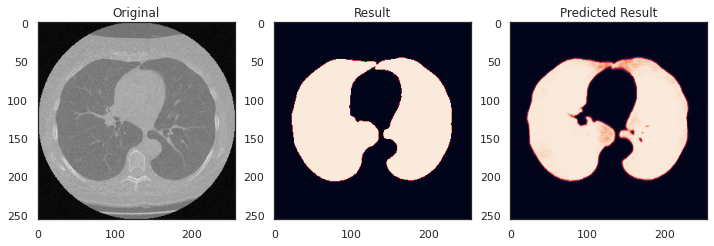

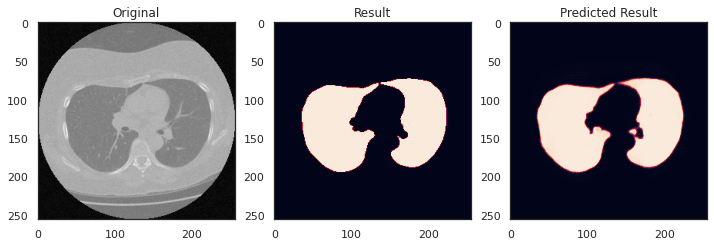

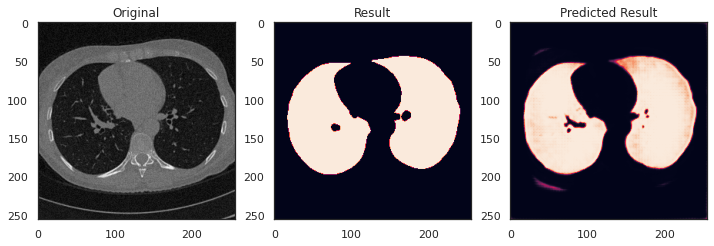

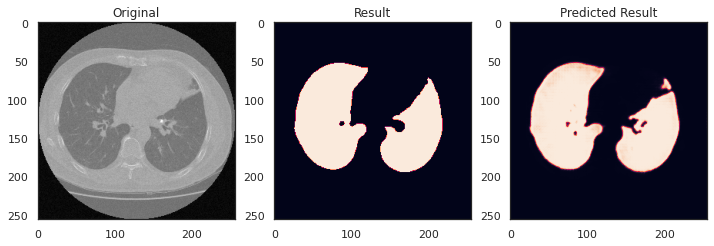

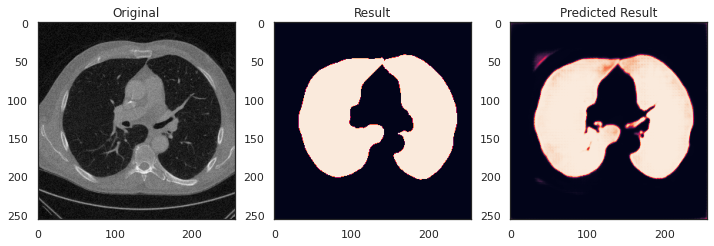

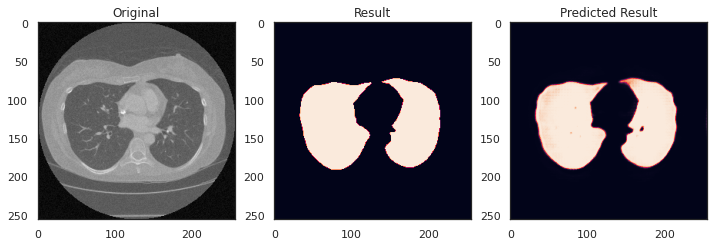

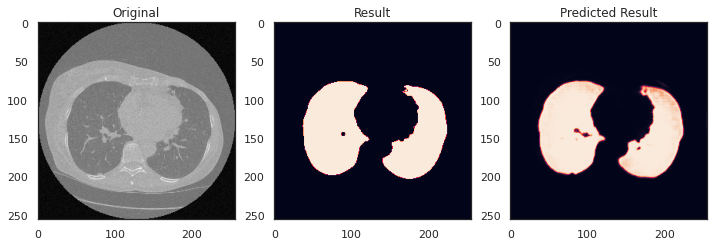

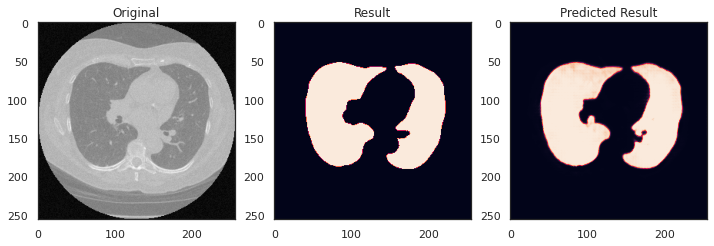

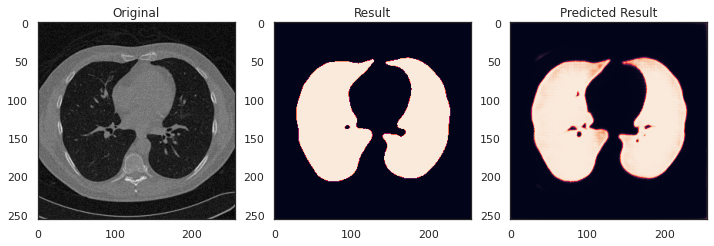

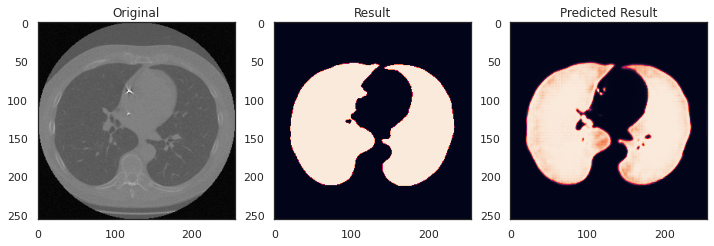

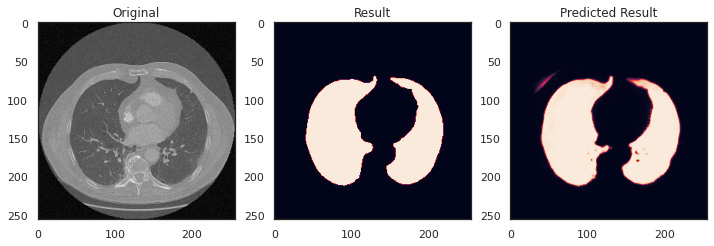

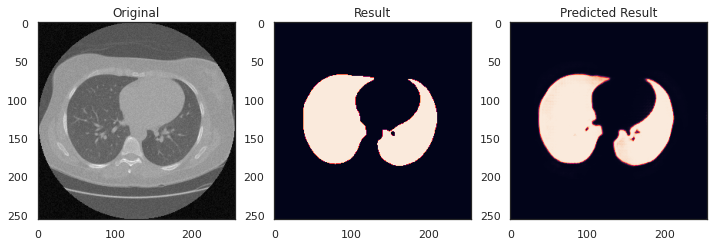

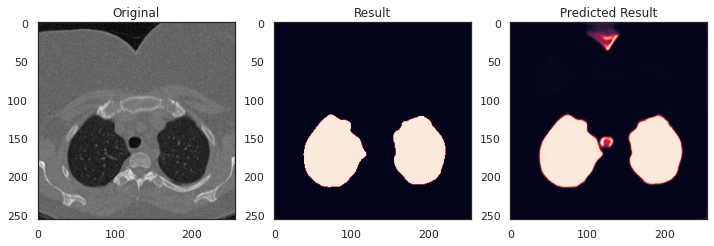

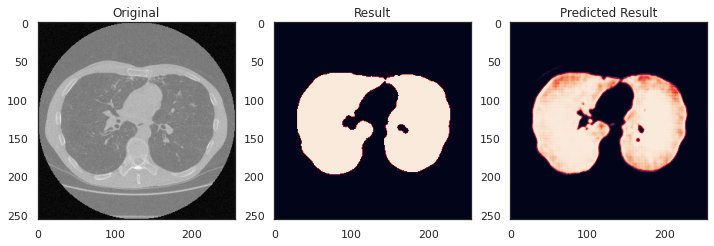

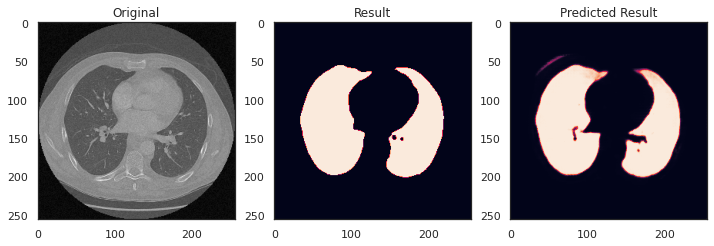

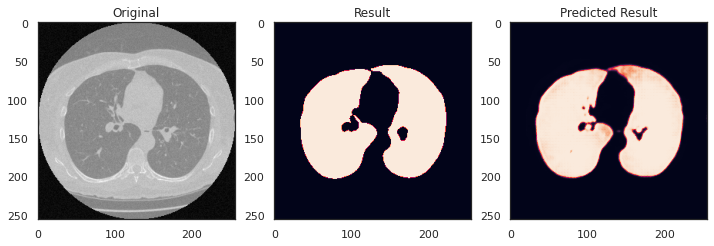

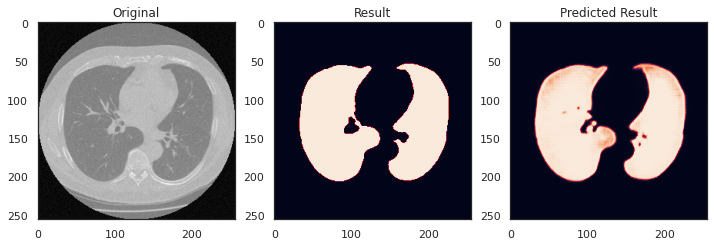

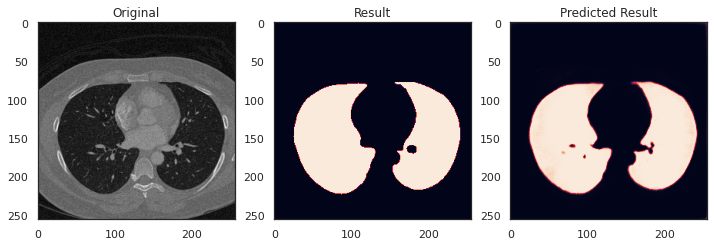

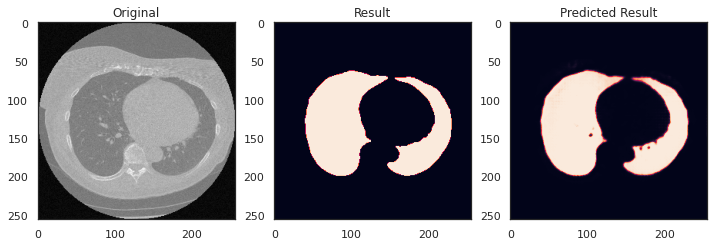

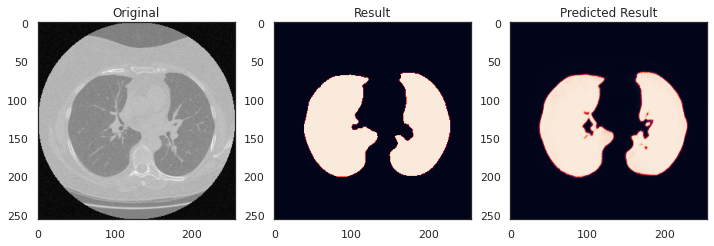

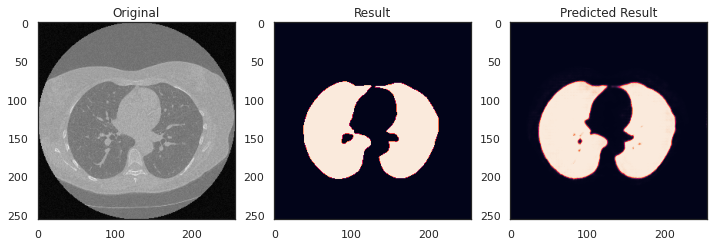

In [18]:
y_predict = model.predict(X_test)

for i in range(X_test.shape[0]): 
    fig, ax = plt.subplots(1,3,figsize=(12,6))
    ax[0].set_title('Original')
    ax[1].set_title('Result')
    ax[2].set_title('Predicted Result')
    ax[0].imshow(X_test[i,:,:,0], cmap='gray')
    ax[1].imshow(y_test[i,:,:,0])
    ax[2].imshow(y_predict[i,:,:,0])

In [21]:
!wget -nc https://raw.githubusercontent.com/brpy/colab-pdf/master/colab_pdf.py
from colab_pdf import colab_pdf
colab_pdf('Unet-keras-kaggle.ipynb')

File ‘colab_pdf.py’ already there; not retrieving.





[NbConvertApp] Converting notebook /content/drive/MyDrive/Colab Notebooks/Unet-keras-kaggle.ipynb to pdf
/usr/local/lib/python3.7/dist-packages/nbconvert/filters/datatypefilter.py:41: UserWarning: Your element with mimetype(s) dict_keys(['application/vnd.colab-display-data+json']) is not able to be represented.
  mimetypes=output.keys())
[NbConvertApp] Support files will be in Unet-keras-kaggle_files/
[NbConvertApp] Making directory ./Unet-keras-kaggle_files
[NbConvertApp] Making directory ./Unet-keras-kaggle_files
[NbConvertApp] Making directory ./Unet-keras-kaggle_files
[NbConvertApp] Writing 102392 bytes to ./notebook.tex
[NbConvertApp] Building PDF
[NbConvertApp] Running xelatex 3 times: ['xelatex', './notebook.tex', '-quiet']
[NbConvertApp] Running bibtex 1 time: ['bibtex', './notebook']
[NbConvertApp] WARNING | bibtex had problems, most likely because there were no citations
[NbConvertApp] PDF successfully created
[NbConvert

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

'File ready to be Downloaded and Saved to Drive'